In [1]:
import os, glob
import numpy as np
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyfits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Ok, so we have extracted the relevant stars from the Gaia catalog and transformed them to xi/eta coordinates generating the file xi_eta_grtrans_out.dat. Next we need to use these xi/eta coordinates (found in columns 5 & 6 of the aforementioned file) to transform the Gaia catalog sources to the astrometric reference image using grmatch. I ran the script cmrawphot_part1.py to scour the options parameter space in order to find a good fit. Check out that script in this repository if you like. You shouldn't need to do anything with it, however. To match the reference image to the Gaia catalog the script calls the grmatch command using the files xi_eta_grtrans_out.dat and k2mosaic-q04-ch81-cad12123.fistar (the photoreference fistar file ). This could be done in one simple line of code, but instead we will vary the parameters: order, maxref, and maxinp. There is lots of information on these parameters here:https://fitsh.net/wiki/man/grmatch   

Essentially, it runs this command below and I check the quality of the fit by reading the itrans output.

In [2]:
maxes=np.arange(200,205,1)
orders=[1,2]
for i in orders:
    for j in maxes:
        cmd='grmatch --input-reference /Users/msoaresfurtado/Desktop/xi_eta_grtrans_out.dat --input /Users/msoaresfurtado/Desktop/k2mosaic-q04-ch81-cad12123.fistar --col-ref 5,6 --col-ref-ordering -4 --col-inp 2,3 --col-inp-ordering 8 --order ' + str(i) + ' --max-distance 1 --triangulation unitarity=0.01,maxref='+str(j)+',maxinp='+str(j)+',mixed --fit iterations=4  --weight reference,column=4,magnitude,power=2 --comment  --output-transformation temp_output/reference_to_gaia_'+str(i)+'_'+str(j)+'.trans --output-matched temp_output/reference_gaia_matched_' + str(i)+'_'+str(j)+'.txt'
        print(cmd,'\n')
        os.system(cmd)
        break

grmatch --input-reference /Users/msoaresfurtado/Desktop/xi_eta_grtrans_out.dat --input /Users/msoaresfurtado/Desktop/k2mosaic-q04-ch81-cad12123.fistar --col-ref 5,6 --col-ref-ordering -4 --col-inp 2,3 --col-inp-ordering 8 --order 1 --max-distance 1 --triangulation unitarity=0.01,maxref=200,maxinp=200,mixed --fit iterations=4  --weight reference,column=4,magnitude,power=2 --comment  --output-transformation temp_output/reference_to_gaia_1_200.trans --output-matched temp_output/reference_gaia_matched_1_200.txt 

grmatch --input-reference /Users/msoaresfurtado/Desktop/xi_eta_grtrans_out.dat --input /Users/msoaresfurtado/Desktop/k2mosaic-q04-ch81-cad12123.fistar --col-ref 5,6 --col-ref-ordering -4 --col-inp 2,3 --col-inp-ordering 8 --order 2 --max-distance 1 --triangulation unitarity=0.01,maxref=200,maxinp=200,mixed --fit iterations=4  --weight reference,column=4,magnitude,power=2 --comment  --output-transformation temp_output/reference_to_gaia_2_200.trans --output-matched temp_output/refer

Here is a breakdown of some of the options included:

1. *order* specifies the polynomial order of the resulted geometrical transformation. It can be arbitrary positive integer. Note that if the order is A, at least (A+1)*(A+2)/2 valid points are needed both from the reference and both from the input file to fit the transformation. The params maxref and maxinp specifiy the maximal number of points which are used for triangulation. We are iterating to get the best fit possible for our catalog.


*--weight reference,column=4,magnitude,power=2* allows me to weight the match by the Gaia magnitudes in the reference file, which are provided in column 4. I am specifying that they are "magnitudes" in order to convert the values to flux (which is what is provided in the fistar). For the maximum-likelihood estimation of an assumed Gaussian distribution, the weights should be the second power of the fluxes. 

I am saving the outputted files in the subdirectory temp_output. The python script takes a bit to run in its entirety (without the break), so I'd take a quick 30 minute break and come back. 

The generated files come in two formats. Here is an example: reference_to_gaia_1_1000.trans and reference_gaia_matched_1_1000.txt. The first number corresponds to the order and the second to the maxref/maxinp values. If no files were generated, just copy and paste the print statements in the cell above directly into your terminal (with the corrected pathways for your computer, of course). 

The first file (reference_to_gaia_1_1000.trans) provides the astrometric solution and quality of fit for the Gaia frame. The second file is the actual matched catalog. 

Ok, we look through the output files to find the best match. We use this this file to match our Gaia catalog to the reference frame.

First we will define two functions. The first (value_to_optimize) will determine the goodness of fit. The second (number_of_matched) will tell us the number of matched sources obtained for that particular transformation.

Let's find the best percentage of matched sources across the two files.

Number of files: 211 

best ratio value is: 96.33%
 corresponding to index value 65
best file is: /Users/msoaresfurtado/Desktop/temp_output/reference_gaia_matched_1_100_165_597_290.5004083333_38.339662222222_2_3_power2_iter2_dist2_allgaia_full_mixed.trans
total sources matched: 1339
unitarity: 0.00126702


Text(0, 0.5, 'unitarity')

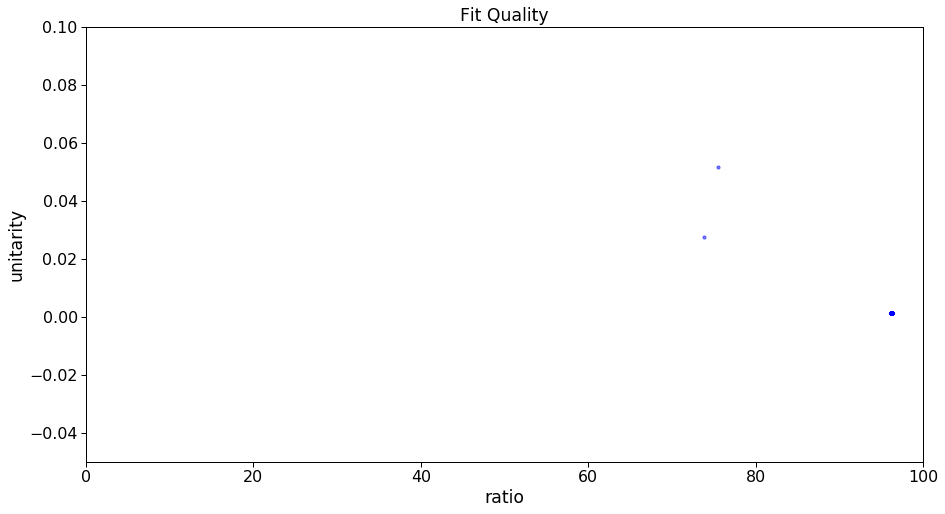

In [3]:
files_to_check= sorted(glob.glob("/Users/msoaresfurtado/Desktop/temp_output/*.trans"))
print("Number of files: " + str(len(files_to_check)),'\n')

def weighted_residual(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        weighted_residual = float(lines[13].split()[2])
        return(weighted_residual)

def unitarity(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        unitarity = float(lines[14].split()[2])
        return(unitarity)

def nmatched(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        nmatched = float(lines[15].split()[2])
        return(nmatched)

def ratio(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        ratio = float(lines[16].split()[2])
        return(ratio)

val1 = [ratio(f) for f in files_to_check]
val2=[nmatched(f) for f in files_to_check]
val3=[unitarity(f) for f in files_to_check]
print ("best ratio value is: " + str(np.nanmax(val1))+'%')
argmax = np.nanargmax(val1)
print (" corresponding to index value " + str(argmax))
max_filename = files_to_check[argmax]
print('best file is: '+str(max_filename))
print('total sources matched:',int(val2[argmax]))
print('unitarity:',(val3[argmax]))

plt.figure(figsize=(15,8))
sns.set_context("paper", font_scale=1.8)
plt.scatter(val1,val3,color='blue',linewidth=1,s=10,alpha=0.5)
plt.xlim(0,100)
plt.ylim(-0.05,0.1)
plt.title('Fit Quality')
plt.xlabel('ratio')
plt.ylabel('unitarity')

We also want the unitarity value to be low. Let's try to optimize on that.

In [4]:
tmp = 0.01
for files in files_to_check:
    with open(files, 'r') as f:
        lines = f.readlines()
        ratio = float(lines[16].split()[2])
        unitarity = float(lines[14].split()[2])
        if ratio>96 and unitarity<tmp and unitarity>0:
            tmp=unitarity
            best=(files)
print(best)
print(tmp)

/Users/msoaresfurtado/Desktop/temp_output/reference_gaia_matched_1_178_178_597_290.5004083333_38.339662222222_2_3_power2_iter2_dist2_allgaia_full_mixed.trans
0.00121446


Great, so this is our winner!

Now we can run the two commands below using the appropriate pathways. This runs grtrans on the Gaia catalog to match coordinates to the astrometric reference frame.

# perform grtrans on you best selected gaia translation solution. 

In [5]:
cmdline='grtrans --input /Users/msoaresfurtado/Desktop/temp_output/reference_gaia_matched_1_178_178_597_290.5004083333_38.339662222222_2_3_power2_iter2_dist2_allgaia_full_mixed.txt --col-xy 5,6 --input-transformation /Users/msoaresfurtado/Desktop/temp_output/reference_gaia_matched_1_178_178_597_290.5004083333_38.339662222222_2_3_power2_iter2_dist2_allgaia_full_mixed.trans --col-out 20,21 --output /Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/gaiaxrK2_transformed_to_astrometricref.txt'
print(cmdline)

grtrans --input /Users/msoaresfurtado/Desktop/temp_output/reference_gaia_matched_1_178_178_597_290.5004083333_38.339662222222_2_3_power2_iter2_dist2_allgaia_full_mixed.txt --col-xy 5,6 --input-transformation /Users/msoaresfurtado/Desktop/temp_output/reference_gaia_matched_1_178_178_597_290.5004083333_38.339662222222_2_3_power2_iter2_dist2_allgaia_full_mixed.trans --col-out 20,21 --output /Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/gaiaxrK2_transformed_to_astrometricref.txt


You should now have the file gaiaxrK2_transformed_to_astrometricref.txt --- open it and make sure that it exists.

In [6]:
xi_eta_file='/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/xi_eta_grtrans_out.dat'
trans_file='/Users/msoaresfurtado/Desktop/temp_output/reference_gaia_matched_1_178_178_597_290.5004083333_38.339662222222_2_3_power2_iter2_dist2_allgaia_full_mixed.trans'
trans_txt_file='/Users/msoaresfurtado/Desktop/temp_output/reference_gaia_matched_1_178_178_597_290.5004083333_38.339662222222_2_3_power2_iter2_dist2_allgaia_full_mixed.txt'
cmdline='grtrans --input %s --col-xy 5,6 --input-transformation %s --col-out 7,8 --output gaia_full_transformed_to_astrometricref.txt' % (xi_eta_file,trans_file)
print(cmdline)

grtrans --input /Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/xi_eta_grtrans_out.dat --col-xy 5,6 --input-transformation /Users/msoaresfurtado/Desktop/temp_output/reference_gaia_matched_1_178_178_597_290.5004083333_38.339662222222_2_3_power2_iter2_dist2_allgaia_full_mixed.trans --col-out 7,8 --output gaia_full_transformed_to_astrometricref.txt


You should now have the file gaia_full_transformed_to_astrometricref.txt --- open it and make sure that it exists.

Next we will remove the unusable sources that fall outside our frame. We do this by removing sources with negative pixel values. Many of those Gaia stars can be eliminated at this step.

In [7]:
# This code takes the output of grtrans_cropped_transform_fullgaia_to_pixel.sh
# and finds all the negative pixel values (from transforming Gaia
# entries outside the image) and removes them from the catalog

# Values to define region of image
min_x = 0.
min_y = 0.
max_x = 300.
max_y = 150.
notch_y_min = 100.
notch_x1_max = 50.
notch_x2_min = 250.

# A reminder that the catalog defines (0.5, 0.5) to be the pixel center,
# and thus (0, 0) is in the lower corner of the origin pixel.  Thus,
# no need to change the values above to "re-center" them.

def in_image(x,y):
    """
    This takes in an x,y value and then decides whether the tuple falls on
    the image, and if it does returns True and if not returns False
    """
    if x > min_x and x < max_x and y > min_y and y < max_y:
        if y < notch_y_min:
            return True
        else:
            if x > notch_x1_max and x < notch_x2_min:
                return True
            else:
                return False
    else:
        return False

# Read in data
with open("/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/gaia_full_transformed_to_astrometricref.txt","r") as f:
    lines = f.readlines()

# Now decide which lines to keep
lines_to_keep = []
num_not_keeping = 0
for line in lines:
    temp = line.split()
    x = float(temp[-2]); y = float(temp[-1])
    if in_image(x,y):
        lines_to_keep.append(line)
    else:
        num_not_keeping += 1

print (num_not_keeping, "lines removed, out of ", len(lines), "total lines.")

with open("/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/gaia_full_transformed_to_astrometricref_negativesremoved.txt","w") as f:
    for line in lines_to_keep:
        f.write(line)

print ("Done!")

101733 lines removed, out of  103538 total lines.
Done!


You should now have the file gaia_full_transformed_to_astrometricref_negativesremoved.txt --- open it and make sure that it exists.

Ok, now we are ready to perform the photometry!!! This is the big step that we have been waiting for. :)

In [8]:
apertures='2.5:5.0:6.0,\
2.6:5.0:6.0,\
2.7:5.0:6.0,\
2.8:5.0:6.0,\
2.9:5.0:6.0,\
3.0:5.0:6.0,\
3.1:5.0:6.0,\
3.2:5.0:6.0,\
3.3:5.0:6.0,\
3.4:5.0:6.0,\
3.5:5.0:6.0,\
3.55:5.0:6.0,\
3.6:5.0:6.0,\
3.65:5.0:6.0,\
3.7:5.0:6.0,\
3.75:5.0:6.0,\
3.8:5.0:6.0,\
3.85:5.0:6.0,\
3.9:5.0:6.0,\
3.95:5.0:6.0'

In [9]:
photref='/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/photref.fits'
transformed_to_astrometric='/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/gaiaxrK2_transformed_to_astrometricref.txt' 
cmdline='fiphot --input %s --input-list %s --col-id 1 --col-xy 20,21 --col-mag 4 --apertures %s \
--sky-fit mode,iterations=4,sigma=3 --disjoint-radius 2 --format IXY-----,sMm --comment \
--output-raw-photometry output/fiphot_output_raw_photometry_full.txt \
--output output/fiphot_output_full.txt' % \
(photref,transformed_to_astrometric,apertures)
print(cmdline)

fiphot --input /Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/photref.fits --input-list /Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/gaiaxrK2_transformed_to_astrometricref.txt --col-id 1 --col-xy 20,21 --col-mag 4 --apertures 2.5:5.0:6.0,2.6:5.0:6.0,2.7:5.0:6.0,2.8:5.0:6.0,2.9:5.0:6.0,3.0:5.0:6.0,3.1:5.0:6.0,3.2:5.0:6.0,3.3:5.0:6.0,3.4:5.0:6.0,3.5:5.0:6.0,3.55:5.0:6.0,3.6:5.0:6.0,3.65:5.0:6.0,3.7:5.0:6.0,3.75:5.0:6.0,3.8:5.0:6.0,3.85:5.0:6.0,3.9:5.0:6.0,3.95:5.0:6.0 --sky-fit mode,iterations=4,sigma=3 --disjoint-radius 2 --format IXY-----,sMm --comment --output-raw-photometry output/fiphot_output_raw_photometry_full.txt --output output/fiphot_output_full.txt


This generated two files in a subdirectory called output. One is fiphot_output_raw_photometry_full.txt and the other is output/fiphot_output_full.txt. 

Take a moment to explore these files.

We need to take a quick detour and convert our Gmags to Kepler magnitudes. 

# You can skip the steps until the next header...

That conversion is dependent on the aperture size...

In [33]:
aperture_sizes_tmp=[x.strip() for x in apertures.split(',')]
aperture_sizes=[x.split(':')[0] for x in aperture_sizes_tmp]
aperture_sizes

['2.5',
 '2.6',
 '2.7',
 '2.8',
 '2.9',
 '3.0',
 '3.1',
 '3.2',
 '3.3',
 '3.4',
 '3.5',
 '3.55',
 '3.6',
 '3.65',
 '3.7',
 '3.75',
 '3.8',
 '3.85',
 '3.9',
 '3.95']

2.5 pixels will be our main aperture with an index value of 0

In [34]:
index=aperture_sizes.index(str(2.5))
print(index)

0


In [35]:
dff = pd.read_table('/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/output/fiphot_output_raw_photometry_full.txt', skiprows=3, \
                    delim_whitespace=True,header=None)
print(dff[0:5])
fiphot_raw_ids=dff[0]
fiphot_raw_fluxes=dff[9]
fiphot_gaia_G_magnitudes=dff[4]
print(fiphot_raw_ids[12:25])
print(fiphot_raw_fluxes[12:25])
print(fiphot_gaia_G_magnitudes[12:25])

                  0        1         2    3         4    5    6    7    8    \
0  205286511045510720  941.424   116.709   20  14.41962  0.0  2.5  5.0  6.0   
1  205262479844643020  833.764   924.303   20  11.99301  0.0  2.5  5.0  6.0   
2  205259627556067955  526.959  1030.411   20  14.52212  0.0  2.5  5.0  6.0   
3  205260775601563712  470.891   847.832   20  15.31675  0.0  2.5  5.0  6.0   
4  205129665711806387  204.705   726.012   20  16.56558  0.0  2.5  5.0  6.0   

         9    ...  116        117        118     119   120  121  122  \
0   24993.10  ...  6.0   28782.10   169.8560  0x0001  3.95  5.0  6.0   
1  204318.00  ...  6.0  214195.00   467.5790  0x0001  3.95  5.0  6.0   
2   12020.30  ...  6.0    8639.52  1555.3100  0x0001  3.95  5.0  6.0   
3    9027.80  ...  6.0   12457.70   286.2880  0x0001  3.95  5.0  6.0   
4    3273.47  ...  6.0    4277.41    84.1844  0x0001  3.95  5.0  6.0   

         123       124     125  
0   29247.20   171.222  0x0001  
1  214251.00   467.696  0x

In [36]:
fiphot_raw_ids = np.genfromtxt("/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/output/fiphot_output_raw_photometry_full.txt",dtype=int, usecols=0)
fiphot_raw_fluxes = np.genfromtxt("/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/output/fiphot_output_raw_photometry_full.txt",usecols=9)
fiphot_gaia_G_magnitudes = np.genfromtxt("/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/output/fiphot_output_raw_photometry_full.txt", usecols=4)
print(fiphot_raw_ids[12:25])
print(fiphot_raw_fluxes[12:25])
print(fiphot_gaia_G_magnitudes[12:25])

[205263459097191910 205286668670042176 205295547656748697
 205131778835727808 205110719752276224 205260019687321856
 205261710186452390 205110716316301158 205284555976302681
 205286480121747059 205286590072924083 205286335810876876
 205285287838394508]
[ 37990.8  297677.    16589.9    5863.41   7474.74  24833.8       0.
   1397.35  51877.8   54088.5   31484.     3839.39  60010.  ]
[13.81202 11.64561 14.80733 15.86203 15.72931 14.29886 14.71906 17.69895
 13.52843 13.5209  14.1218  15.75191 13.34695]


Let's make a quick list of twenty bright, isolated stars for which to do the Gaia magnitude conversion. We will want to ensure that we've chosen isolated stars, but we will not know if that is certain until after we have light curves. Thus, we may iterate through this step multiple times. 

We actually need to begin by appending the BJD to the subtracted files. I do this with the script get_bjd.py and insert_BJD.py.

In [37]:
bright_id_list=[]
bright_id_cat_indices=[]
badindices=[13,25,40,50,51,72,73,84,95,106,107,108,112,121,125,146,150,163,186,210,235,236,241,257,272,278,\
            283,284,322,328]
y=0
while len(bright_id_list)<20:
    if (fiphot_gaia_G_magnitudes[y]>10) and (fiphot_gaia_G_magnitudes[y]<13.0) and (y not in badindices):
        bright_id_list.append(fiphot_raw_ids[y])
        bright_id_cat_indices.append(y)
    y=y+1
print(bright_id_list[1:4],bright_id_cat_indices[1:4])

[205283398053245516, 205110561697470425, 205259933787979878] [37, 97, 130]


Let's find the indices for these bright stars in our file fiphot_output_raw_photometry_full.txt too

In [38]:
bright_id_phot_indices = []
for i in range(len(bright_id_list)):
    for j in range(len(fiphot_raw_ids)):
        if bright_id_list[i] == fiphot_raw_ids[j]:
            bright_id_phot_indices.append(j)
            print(j,fiphot_raw_ids[j],fiphot_gaia_G_magnitudes[j])
            break
    else:
        print("Warning!  Warning!  Did not find a match for this Gaia ID in K2:")
        print(str(bright_id_list[i]) + ",  which is index " + str(i))

1 205262479844643020 11.99301
37 205283398053245516 10.25358
97 205110561697470425 11.49217
130 205259933787979878 12.00671
132 205283178150850508 12.09269
143 205284023400350630 10.75377
196 205283985604643212 11.54373
233 205129390403769625 12.07441
248 205109053304978867 11.4953
250 205295547226915648 12.1242
258 205264743721439705 11.90788
262 205282549367625574 12.87896
268 205286682413937548 11.70118
273 205280151057798233 11.50887
279 205262778344406643 10.64898
288 205136561711440345 12.30597
294 205282322593336883 11.96012
303 205284982037045286 12.95771
329 205110585749290560 12.68632
337 205283349949474060 11.90418


/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
No handles with labels found to put in legend.


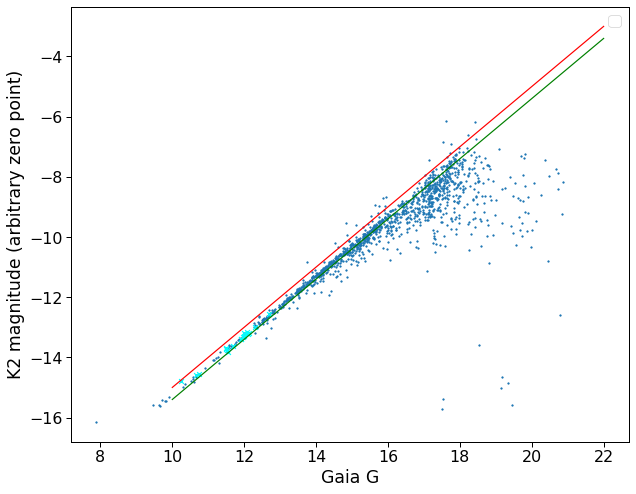

In [39]:
def linear(x,m,b):
    return np.multiply(m,x) + b

plt.figure(figsize=(10,8))
sns.set_context("paper", font_scale=1.8)
upper_line = [1,-25]
lower_line = [1,-25.4]

plt.scatter(fiphot_gaia_G_magnitudes,-2.5*np.log10(fiphot_raw_fluxes),s=2)
plt.scatter(fiphot_gaia_G_magnitudes[bright_id_phot_indices],
            -2.5*np.log10(fiphot_raw_fluxes[bright_id_phot_indices]),
            color='cyan',marker='x')
plt.plot([10,22],linear([10,22],upper_line[0],upper_line[1]),color="red")
plt.plot([10,22],linear([10,22],lower_line[0],lower_line[1]),color="green")
plt.xlabel("Gaia G")
plt.ylabel("K2 magnitude (arbitrary zero point)")
plt.legend()
plt.show()


Great, so the relation above illustrates the Gaia Gmag to Kepler magnitude conversion. Let's get a fit for this relation.

In [40]:
# First, the functions to fit                                                                
def single_linear_fit(X, a, c):
    """                                                                                      
    x should be one dimensional,  perhaps Gaia_G                                             
    """
    return np.multiply(a,X) + c

def single_linear_fit_mod(X, c):
    """                                                                                      
    x should be one dimensional,  perhaps Gaia_G                                             
    """
    return X + c

# Now the fit analyzer                                                                       
def squared_distance(X, Y, function, function_params):
    """                                                                                      
    This measures the sum of the squared distances for each point between                    
    Y and function(X).                                                                       
    """
    function_Y = function(X, *function_params)

    sum_squared_distance = 0.
    for i in range(len(Y)):
        sum_squared_distance += (Y[i] - function_Y[i])**2
    return sum_squared_distance


In [41]:
Gaia_ID_using, Gaia_G_using, fiphot_raw_flux_using = zip(*[ [ID, g, flux] for
                                   ID, g, flux in
                                   zip(fiphot_raw_ids, fiphot_gaia_G_magnitudes,
                                      fiphot_raw_fluxes) if -2.5*np.log10(flux)
                                       < linear(g,upper_line[0],upper_line[1])
                                       and -2.5*np.log10(flux) > linear(g,
                                       lower_line[0],lower_line[1]) ])
print(len(Gaia_ID_using))


559


/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(0, 0.5, 'K2 magnitude (arbitrary zero point)')

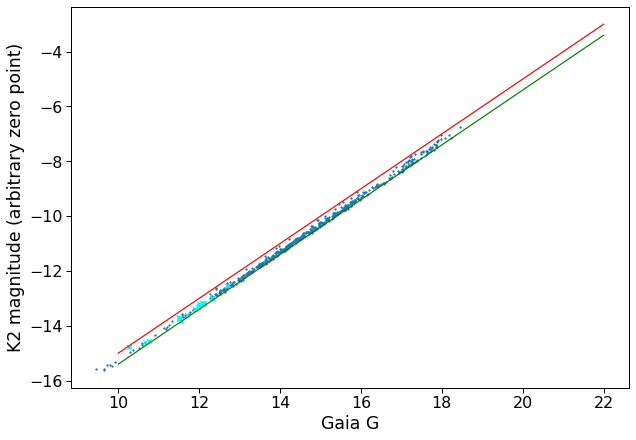

In [42]:
plt.figure(figsize=(10,7))
sns.set_context("paper", font_scale=1.8)
plt.scatter(Gaia_G_using, -2.5*np.log10(fiphot_raw_flux_using),s=2)
plt.scatter(fiphot_gaia_G_magnitudes[bright_id_phot_indices],
            -2.5*np.log10(fiphot_raw_fluxes[bright_id_phot_indices]),
            color='cyan',marker='x')
plt.plot([10,22],linear([10,22],upper_line[0],upper_line[1]),color="red")
plt.plot([10,22],linear([10,22],lower_line[0],lower_line[1]),color="green")
plt.xlabel("Gaia G")
plt.ylabel("K2 magnitude (arbitrary zero point)")

0.0050365424463778745


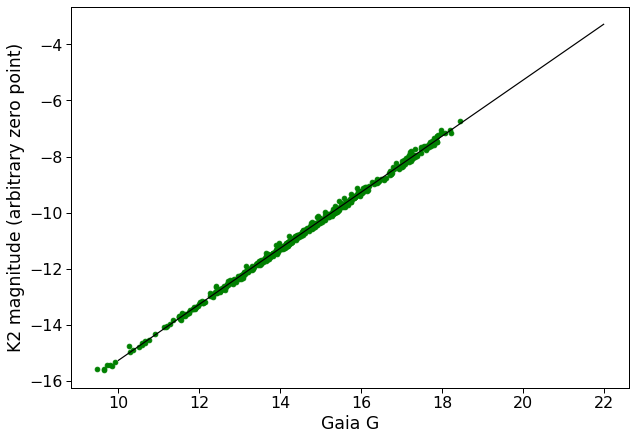

In [43]:
from scipy.optimize import curve_fit

# Let's get the K2 mags that we want from the flux                                                          
converted_flux_to_mag_using = -2.5*np.log10(fiphot_raw_flux_using)

###### Now to actually fit!                                                                  
# Fit of just Gaia G                                                                         
plt.figure(figsize=(10,7))
sns.set_context("paper", font_scale=1.8)
y_fit_1 = curve_fit(single_linear_fit,Gaia_G_using,converted_flux_to_mag_using)
plt.scatter(Gaia_G_using,converted_flux_to_mag_using,color='green')
plt.plot([10,22],single_linear_fit([10,22],*y_fit_1[0]),color='black')
plt.xlabel("Gaia G")
plt.ylabel("K2 magnitude (arbitrary zero point)")
gaia_G_chi2 = squared_distance(Gaia_G_using,converted_flux_to_mag_using,
                               single_linear_fit, y_fit_1[0])
print(gaia_G_chi2/(len(Gaia_G_using) - 1 - 2))

Now we can actually fit the data. 

0.005028217595604372
(array([-25.27668955]), array([[8.97890244e-06]]))


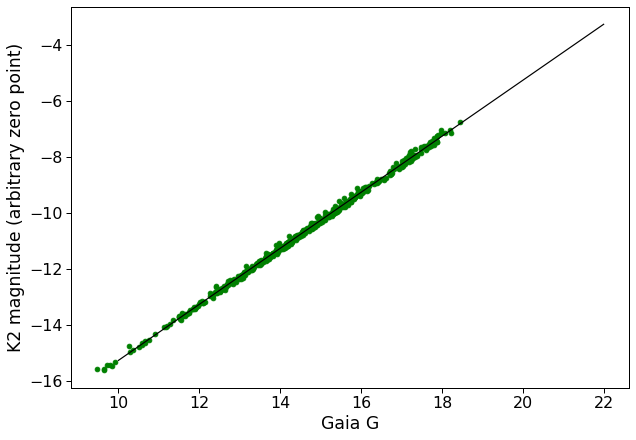

In [44]:
plt.figure(figsize=(10,7))
y_fit_1p5 = curve_fit(single_linear_fit_mod,Gaia_G_using,converted_flux_to_mag_using)
plt.scatter(Gaia_G_using,converted_flux_to_mag_using,color='green')
plt.plot([10,22],single_linear_fit_mod([10,22],*y_fit_1p5[0]),color='black')
plt.xlabel("Gaia G")
plt.ylabel("K2 magnitude (arbitrary zero point)")
gaia_G_chi2_1p5 = squared_distance(Gaia_G_using,converted_flux_to_mag_using,
                               single_linear_fit_mod, y_fit_1p5[0])
print(gaia_G_chi2_1p5/(len(Gaia_G_using) - 1 - 1))
print(y_fit_1p5)
np.savetxt("best_fit_value.txt",y_fit_1p5[0])


We have a best fit value of -25.26116502

Next we will fit a Gaussian to magnitude as a function of aperture size to know how to extrapolate from the "zero-point" aperture size

First let's define some functions that we will need

In [45]:
from scipy.integrate import quad
from scipy.special import jv as j_bessel
from scipy.optimize import curve_fit

def gaussian(x, A, sigma):
    return 2*A*np.exp(-np.power(x,2.)/(sigma*sigma) )

def integral_of_gaussian(x, A, sigma):
    to_return = []
    try:
        for i in range(len(x)):
            to_return.append(quad(gaussian, 0., x[i], args=(A, sigma))[0])
    except TypeError:
        to_return = quad(gaussian, 0., x, args=(A, sigma))[0]
    return to_return


def moffat(x, A, alpha, beta):
    x_use = x #- x_offset
    return A * np.power(1 + x_use*x_use/(alpha*alpha),-beta)

def integral_of_moffat(x, A, alpha, beta):
    to_return = []
    for i in range(len(x)):
        to_return.append(quad(moffat, 0., x[i], args=(A, alpha, beta))[0])
    return to_return


def airy(x, P0, ka):
    theta = x * 1.93e-8
    return P0*(1. - np.power(j_bessel(0,np.multiply(ka,np.sin(theta))),2) - np.power(j_bessel(1,np.multiply(ka,np.sin(theta))),2))

In [46]:
# Figure out the right indices for the stars that are being used
indices_of_bright_in_rawfiphot = [] # Get the proper indices of the bright stars
for i in range(len(bright_id_list)):
    for j in range(len(fiphot_raw_ids)):
        if bright_id_list[i] == fiphot_raw_ids[j]:
            indices_of_bright_in_rawfiphot.append(j)
            break
    else:
        print ("Warning!  Warning!  Did not find a match for this Gaia ID in K2:")
        print (str(bright_id_list[i]) + ",  which is index " + str(i))

In [47]:
# Get all the fluxes                                                                         
fluxes = []
for i in range(len(aperture_sizes)):
    fluxes.append(np.genfromtxt('/Users/msoaresfurtado/Desktop/output/fiphot_output_raw_photometry_full.txt',usecols=9+i*6))
fluxes

[array([ 24993.1 , 204318.  ,  12020.3 , ...,   1795.18,  12427.1 ,
        882628.  ]),
 array([ 25126.9, 206234. ,  11944.6, ...,   1998.8,  14055.4, 915727. ]),
 array([ 25240.  , 208126.  ,  11752.8 , ...,   2227.56,  16225.4 ,
        948720.  ]),
 array([ 25329.6 , 209500.  ,  11477.4 , ...,   2484.17,  18600.9 ,
        981622.  ]),
 array([  25400.7 ,  210471.  ,   11171.8 , ...,    2770.28,   20924.5 ,
        1011590.  ]),
 array([  25463.1,  211238. ,   10863.6, ...,    3084.4,   23155.4,
        1036270. ]),
 array([  25521.  ,  211862.  ,   10590.  , ...,    3425.29,   25319.9 ,
        1057760.  ]),
 array([  25575.9 ,  212373.  ,   10324.9 , ...,    3792.67,   27381.5 ,
        1078770.  ]),
 array([  25630.1 ,  212788.  ,   10067.6 , ...,    4209.65,   29333.8 ,
        1099630.  ]),
 array([  25781.4 ,  213132.  ,    9815.77, ...,    4683.83,   31184.7 ,
        1120350.  ]),
 array([  26119.6 ,  213410.  ,    9563.74, ...,    5198.16,   33096.4 ,
        1140990.  ]),

We next take a number of bright reasonably isolated stars and plot the normalized flux (normalized to the smallest aperture) vs aperture size. It then fits a function to this relation and extrapolate what the flux would be at larger apertures.                                                                                                                                                                            

/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


(-15, -12)

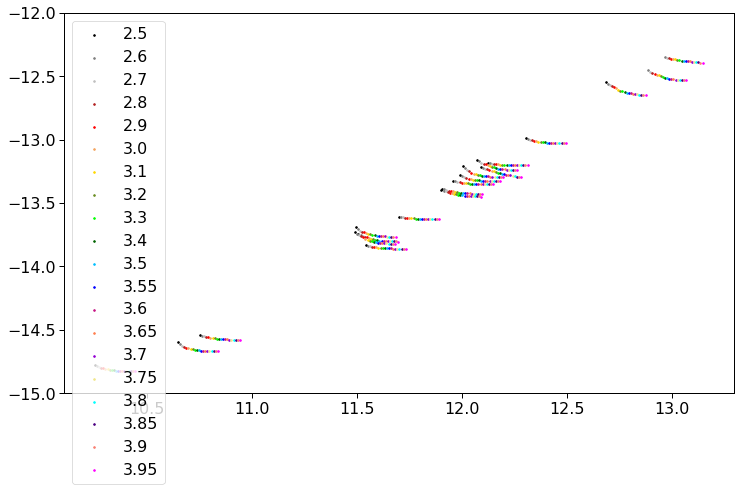

In [48]:
plt.figure(figsize=(12,7))
colors = ['black','gray','silver','firebrick','red','sandybrown','gold','olivedrab',
          'lime','darkgreen','deepskyblue','blue','mediumvioletred','coral',
          'darkviolet','khaki','cyan','indigo','salmon','magenta',
          'brown','deeppink','turquoise','papayawhip']
colors += colors

for i in range(len(aperture_sizes)):
    plt.scatter(np.add(fiphot_gaia_G_magnitudes[indices_of_bright_in_rawfiphot]
                       ,[i*0.01]*len(bright_id_phot_indices)),
                -2.5*np.log10(fluxes[i][bright_id_phot_indices]),
                color=colors[i],s=3,label=aperture_sizes[i])
#for bb in indices_of_bright_in_rawfiphot:
#    plt.scatter(fiphot_gaia_G_magnitudes[bb],-2.5*np.log10(fluxes[i][bb]),s=100,label=bb)
plt.legend()
plt.ylim(-15,-12)

/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


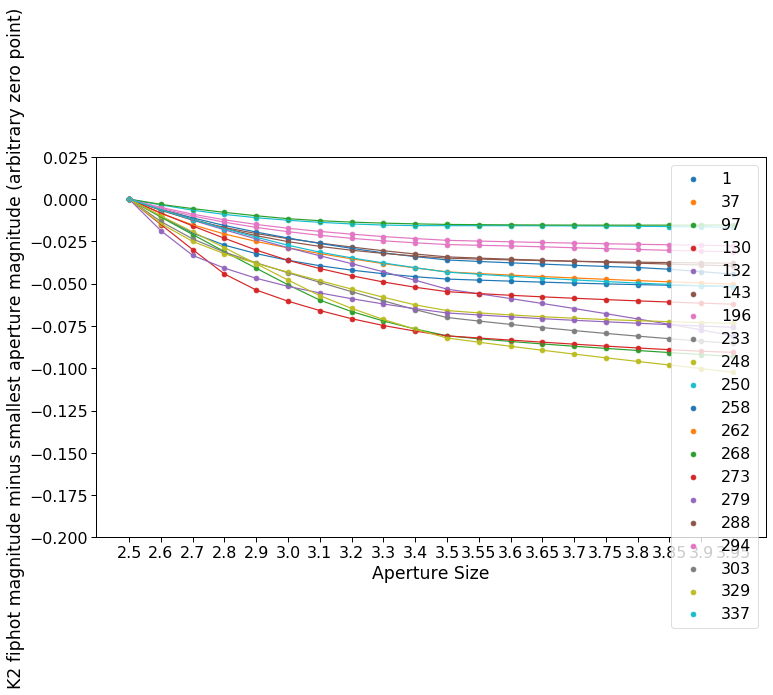

In [49]:
# Now plot mag(r) - mag(smallest r) vs. r
plt.figure(figsize=(12,7))
for i in range(len(indices_of_bright_in_rawfiphot)):
    flux_to_mag = -2.5*np.log10([f[indices_of_bright_in_rawfiphot[i]] for 
                                 f in fluxes])
    y = [mag - flux_to_mag[0] for mag in flux_to_mag]
    plt.plot(aperture_sizes,y)
    plt.scatter(aperture_sizes,y,label=indices_of_bright_in_rawfiphot[i])
plt.xlabel("Aperture Size")
plt.ylabel("K2 fiphot magnitude minus smallest aperture magnitude (arbitrary zero point)")
plt.ylim(-0.2,0.025)
plt.legend()

In [50]:
index_chosenaperture=0 #2.5 pixels is our chosen aperture and it has index zero

# Now to normalize each flux, normalizing to the aperture                                                                                                                                              
normalized_flux_lists = []
for i in range(len(bright_id_list)):
    temp_list = []
    for j in range(len(aperture_sizes)):
        temp_list.append(fluxes[j][indices_of_bright_in_rawfiphot[i]]/
                         fluxes[index_chosenaperture][indices_of_bright_in_rawfiphot[i]])
    normalized_flux_lists.append(temp_list)

/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/msoaresfurtado/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


In [51]:
##########################                                                                                                                                                                             
## Now median the data and then fit                                                                                                                                                                    

median_normalized = []
for j in range(len(normalized_flux_lists[0])):
    temp = []
    for i in range(len(normalized_flux_lists)):
        temp.append( normalized_flux_lists[i][j])
    median_normalized.append(np.nanmedian(temp))

print("median_normalized: ")
print(median_normalized)

median_normalized: 
[1.0, 1.0077019161286656, 1.01439187421916, 1.0203628076162676, 1.0257341158029836, 1.0303710870272456, 1.0341153787165513, 1.037583352725197, 1.0408990054802771, 1.0441390048715342, 1.0473594715118026, 1.0489288477487184, 1.049717043524124, 1.0504485180755374, 1.0511247486492397, 1.0517427098388596, 1.0523105974127516, 1.052830974184744, 1.0533142517926124, 1.0539350984594074]


In [52]:
## Now fit                                                                                                                                                                                             
aperture_sizes_floats = [float(i) for i in aperture_sizes]

gaussian_fit = curve_fit(integral_of_gaussian,aperture_sizes_floats,median_normalized)
print(gaussian_fit[0])
moffat_fit = curve_fit(integral_of_moffat,aperture_sizes_floats,median_normalized,p0=(1.17122126,  8,  4000), maxfev=10000)
print(moffat_fit[0])
airy_fit = curve_fit(airy,aperture_sizes_floats,median_normalized,p0=(1.7,90000000.))
print(airy_fit[0])

[0.32235749 1.84677532]
[0.74663653 2.65013464 3.43938074]
[1.15017965e+00 1.04643759e+08]


In [53]:
#Current fits                                                                                                                                                                                          
#[ 0.42386758  1.33804921]                                                                                                                                                                             
#[  8.47754711e-01   1.14019839e+02   7.26227066e+03]                                                                                                                                                  
#[  1.15506655e+00   9.66223052e+07]                                                                                                                                                                   
np.savetxt("best_gaussian_fit.txt",gaussian_fit[0])

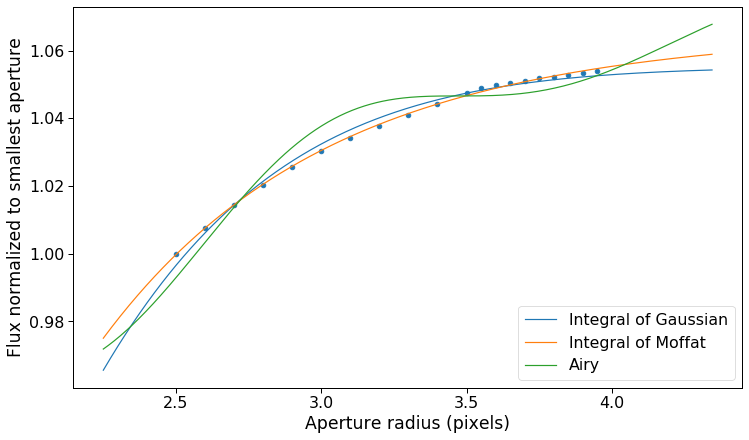

In [54]:
# Now print the fits                                                                                                                                                                                   
plt.figure(figsize=(12,7))
x_touse = np.linspace(0.9*aperture_sizes_floats[0],1.1*aperture_sizes_floats[-1],500)
plt.scatter(aperture_sizes_floats,median_normalized,s=22)
plt.plot(x_touse,integral_of_gaussian(x_touse,*gaussian_fit[0]),label="Integral of Gaussian")
plt.plot(x_touse,integral_of_moffat(x_touse,*moffat_fit[0]),label="Integral of Moffat")
plt.plot(x_touse,airy(x_touse,*airy_fit[0]),label="Airy")
plt.xlabel("Aperture radius (pixels)")
plt.ylabel("Flux normalized to smallest aperture")
plt.legend(loc='lower right')


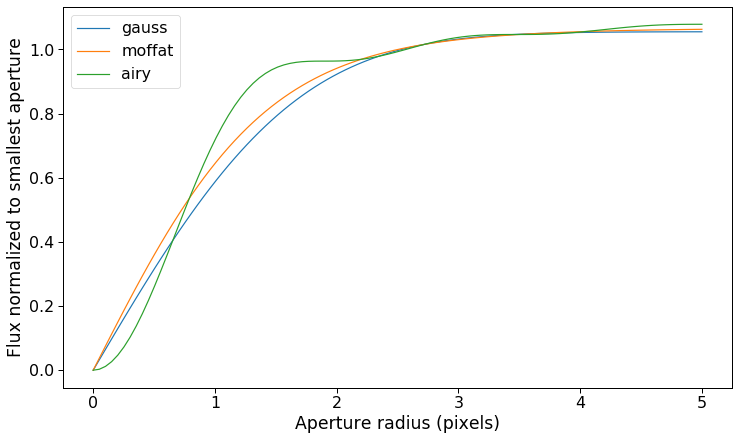

In [55]:
plt.figure(figsize=(12,7))
xish = np.linspace(0,5,100)
plt.plot(xish, integral_of_gaussian(xish, *gaussian_fit[0]), label="gauss")
plt.plot(xish, integral_of_moffat(xish, *moffat_fit[0]), label="moffat")
plt.plot(xish, airy(xish, *airy_fit[0]), label="airy")
plt.xlabel("Aperture radius (pixels)")
plt.ylabel("Flux normalized to smallest aperture")
plt.legend(loc='best')

# Pick back up here. Make sure you have the following two files: best_fit_value.txt and best_gaussian_fit.txt

In [56]:
#from magnitude_fitter import single_linear_fit_mod
#from curve_of_growth_analysis import gaussian
#from curve_of_growth_analysis import integral_of_gaussian

best_fit_value = np.loadtxt("best_fit_value.txt")
best_gaussian_fit = np.loadtxt("best_gaussian_fit.txt")

In [57]:
# Let's read in the necessary info from the raw flux file                                                                                                                                              
Gaia_mag = np.loadtxt("/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/output/fiphot_output_raw_photometry_full.txt",
                               usecols=[4])
Gaia_mag

array([14.41962, 11.99301, 14.52212, ..., 18.52286, 17.33187, 19.32931])

Now we will use the pre-determined best-fit value to the Gaia fit of magnitudes in order to convert the fluxes to proper instrumental fluxes, rather than the potentially blended fluxes. Remember that the resolution of Kepler << than the resolution of Gaia, so we want to use their values and not our own. Our own values are far more likely to be blended. We only want our data to reveal the variations in magnitude.

In [58]:
# Convert to K2 "magnitudes" then flux
flux_mag = single_linear_fit_mod(Gaia_mag, best_fit_value)
flux = np.power(10, np.divide(flux_mag,-2.5)) # this flux is for a chosen aper.
print (flux)
print ([val for val in flux if val < 0.])


[ 22020.53268472 205812.53433353  20036.77496026 ...    502.95811595
   1506.35668976    239.30502629]
[]


Now for each star, for each aperture size, calculate the instrumental flux using the fitted flux for the chosen aperture and the gaussian extrapolation for flux for different aperture sizes.                                                                                                                                                           


In [59]:
list_of_fluxes_over_apertures = []

for i in range(len(aperture_sizes)):
    # Use Gaussian fit to get ratio                                                                                                                                                                    
    if i == index_chosenaperture:
        list_of_fluxes_over_apertures.append(flux)
        continue
    # else, for the other indices                                                                                                                                                                      
    ratio = integral_of_gaussian(float(aperture_sizes[i]), *best_gaussian_fit)
    list_of_fluxes_over_apertures.append([item*ratio for item in flux])


In [60]:
############################################                                                                                                                                                           
# Now read in the file and modify it                                                                                                                                                                   

with open("/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/output/fiphot_output_raw_photometry_full.txt",'r') as f:
    lines = f.readlines()

header_lines = [line for line in lines if line[0] == '#']
print ('Number of header lines: ', len(header_lines))

if len(header_lines) != 3:
    raise RuntimeWarning("Warning! The number of header lines is not three," +
                         " as is to be expected.")

num_initial_characters = 88 # How many characters it takes to get to the                                                                                                                               
            # first flux value                                                                                                                                                                         
num_characters_per_aperture = 49 # How many characters to get to the                                                                                                                                   
            # next flux value                                                                                                                                                                          
num_characters_flux_value = 12 # The number of characters for the value itself                                                                                                                         
w=11 # The maximum width of a number to print out                                                                                                                                                      

lines_to_print = []

for i in range(len(lines) - len(header_lines)):
    temp = lines[i + len(header_lines)]
    for j in range(len(aperture_sizes)):
        num_to_fit_in = list_of_fluxes_over_apertures[j][i]
        p=w-len(str(int(num_to_fit_in)))-1
        if p <=0: # If it's short enough                                                                                                                                                               
            temp_individual_number = " %11f" % list_of_fluxes_over_apertures[j][i]
        else: # If it's too long                                                                                                                                                                       
            temp_individual_number = " {:{w}.{p}f}".format(num_to_fit_in, w=w, p=p)
        num = num_initial_characters + j*num_characters_per_aperture

        if temp[num+num_characters_flux_value] != ' ':
            print ("WARNING! WARNING!")
            print ("There was a flux column that was not followed by a space")
            print ("Instead it was a " + temp[num+num_characters_flux_value])
            print ("Now deleting that character....")
            temp =  temp[:num+num_characters_flux_value] + \
                temp[num+num_characters_flux_value+1:]
        temp = temp[:num] + temp_individual_number + \
             temp[num+num_characters_flux_value:]

    lines_to_print.append(temp)

if len(lines_to_print) != len(lines) - len(header_lines):
    raise RuntimeError("Did not end up with enough lines after processing " +
                       "all\n the lines to be same as original number")

## Now print out the processed output                                                                                                                                                                  
with open("/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/output/fiphot_output_raw_photometry_full_processed.txt",'w') as f:
    for line in header_lines:
        f.write(line)
    for line in lines_to_print:
        f.write(line)

Number of header lines:  3


Phew! All that just for some magnitudes. 

Great, we have substituted the fluxes with more "real" fluxes based on Gaia magnitudes
Next we will run the subtraction photometry on all the Gaia sources and all the frames and all the apertures to perform the actual photometry.


# Next we photometry on all the Gaia sources in all the subtracted frames using all the selected apertures.

In [63]:
#import os, glob
rawphot='/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/output/fiphot_output_raw_photometry_full_processed.txt'
transfiles= sorted(glob.glob("/Volumes/rmathieu/NGC6791/q04c81_justcad15*/*.itrans"))
print('total files in research drive folder:',len(transfiles))
print(transfiles[0:3])

total files in research drive folder: 99
['/Volumes/rmathieu/NGC6791/q04c81_justcad15*/k2mosaic-q04-ch81-cad15100.itrans', '/Volumes/rmathieu/NGC6791/q04c81_justcad15*/k2mosaic-q04-ch81-cad15101.itrans', '/Volumes/rmathieu/NGC6791/q04c81_justcad15*/k2mosaic-q04-ch81-cad15102.itrans']


In [62]:
gain=105.99 #Huang used a gain of 2.1 #Wallace used a gain of 105.99 #Which is better?
gain=str(gain)
for r in transfiles:
    print(r)
    cad=(r.split('-cad')[1])
    cad=cad.split('.itrans')[0]
    print(cad)
    subfile="/Volumes/rmathieu/NGC6791/q04c81_justcad15*/k2mosaic-q04-ch81-cad%s-subtr.fits"%(cad)
    kernel="/Volumes/rmathieu/NGC6791/q04c81_justcad15*/k2mosaic-q04-ch81-cad%s.kernel"%(cad)
    outfile='/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/subtraction_photometry_output/photometry_output_%s.out' % (cad)
    #you will want to run this as a loop...
    #cmdline = "fiphot --input-subtracted %s --input-raw-photometry %s --sky-fit median,iterations=4,sigma=3 --format IXY-----,sMm --gain %s --disjoint-radius 2 --input-kernel %s --comment --output %s" \
    cmdline = "fiphot --input-subtracted %s --input-raw-photometry %s --sky-fit median,iterations=4,sigma=3 --format IXY-----,sMm --gain %s --input-kernel %s --comment --output %s" \
    % (subfile,rawphot,gain,kernel,outfile)
    print(cmdline)
    os.system(cmdline)
    break #remove the break to do the whole she-bang!
    
#GAIN? Do we have the gain set correctly? I emailed Joel to ask about this.

/Volumes/rmathieu/NGC6791/q04c81_justcad15*/k2mosaic-q04-ch81-cad15100.itrans
15100
fiphot --input-subtracted /Volumes/rmathieu/NGC6791/q04c81_justcad15*/k2mosaic-q04-ch81-cad15100-subtr.fits --input-raw-photometry /Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/output/fiphot_output_raw_photometry_full_processed.txt --sky-fit median,iterations=4,sigma=3 --format IXY-----,sMm --gain 105.99 --input-kernel /Volumes/rmathieu/NGC6791/q04c81_justcad15*/k2mosaic-q04-ch81-cad15100.kernel --comment --output /Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/subtraction_photometry_output/photometry_output_15100.out


Remove the break above and run this in your terminal to get the whole she-bang. It will take a while, so this is a good time for a break or just run this on a small subset of frames.

Go ahead and check some of the output here. You should have files in the folder subtraction_photometry_output

# Going forward, be sure you have BJD and NOT cadences...

The Kepler BJD and the cadence should both be included as columns in the Kepler TPF or the Kepler LLC files. Rachel wisely pointed out the the outputted k2mosaic files also possess this information. We are using the average BJD for the entire frame. We should ensure that the percent error is not too high by doing so. This out file is called Cadence_BJD.out. This script can be found in the notebook 200819_Incorporate_BJD.ipynb.

After the script is complte, we can insert the BJD date using the script found in the notebook 200819_Incorporate_BJD.ipynb

The script will operate directly on the photometry output in *subtraction_photometry_output*

Now we generate the light curves using grcollect (fitsh). We collect all the photometric information for each source.

In [72]:
cads= sorted(glob.glob("/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/subtraction_photometry_output/photometry_output*.out"))
cads=[x.split('.out')[0] for x in cads]
cads=[x.split('output_')[1] for x in cads]
print(cads)
dfc = pd.DataFrame(cads, columns=["cadences"])
dfc.to_csv('/Users/msoaresfurtado/Dropbox/Research_NGC6791/Notebooks/lc_cads.dat', index=False)

['15100', '15101', '15102', '15104', '15105', '15106', '15107', '15108', '15109', '15110', '15111', '15112', '15113', '15114', '15115', '15116', '15117', '15118', '15119', '15120', '15121', '15122', '15123', '15124', '15125', '15126', '15127', '15128', '15129', '15130', '15132', '15133', '15134', '15135', '15136', '15137', '15138', '15139', '15140', '15141', '15142', '15143', '15144', '15145', '15146', '15147', '15148', '15149', '15150', '15151', '15152', '15153', '15154', '15155', '15158', '15159', '15160', '15162', '15163', '15164', '15165', '15166', '15167', '15168', '15169', '15170', '15171', '15172', '15173', '15174', '15175', '15176', '15177', '15178', '15179', '15180', '15181', '15182', '15183', '15184', '15185', '15187', '15188', '15189', '15190', '15191', '15192', '15193', '15194', '15195', '15196', '15197', '15198', '15199']


This just generated the file lc_cads.dat --- make sure that it exists

# Make Light Curves: run melinda_make_LCs.sh

Here I ran the bash script melinda_make_LCs.sh --- you will need to make this executable using a chmod command

Running the script created a ton of files in a subdirectory that I've named b0i0d10 --- it is named this way to reflect the kernel parameters

# Inspect your light curves!

Let's look at a light curve!

In [47]:
df=pd.read_table('/Users/msoaresfurtado/Desktop/b0i0d10/2051105612675380000.rlc',delim_whitespace=True,header=None)
#df=df.dropna(how='all', axis=1)
print(df[:5])

     0                    1        2        3  4  5  6  7  8  9   ...  \
0  1914  2051105612675380000  171.053  865.743  -  -  -  -  -  G  ...   
1  1914  2051105612675380000  171.079  868.775  -  -  -  -  -  G  ...   

        59  60        61       62  63        64       65  66        67  \
0  0.00604   G  18.54734  0.00591   G  18.54684  0.00578   G  18.54640   
1  0.00452   G  18.55390  0.00438   G  18.55403  0.00425   G  18.55411   

        68  
0  0.00566  
1  0.00413  

[2 rows x 69 columns]


In [48]:
df

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,1914,2051105612675380000,171.053,865.743,-,-,-,-,-,G,...,0.00604,G,18.54734,0.00591,G,18.54684,0.00578,G,18.54640,0.00566
1,1914,2051105612675380000,171.079,868.775,-,-,-,-,-,G,...,0.00452,G,18.55390,0.00438,G,18.55403,0.00425,G,18.55411,0.00413


Text(0, 0.5, 'Kepler Magnitude')

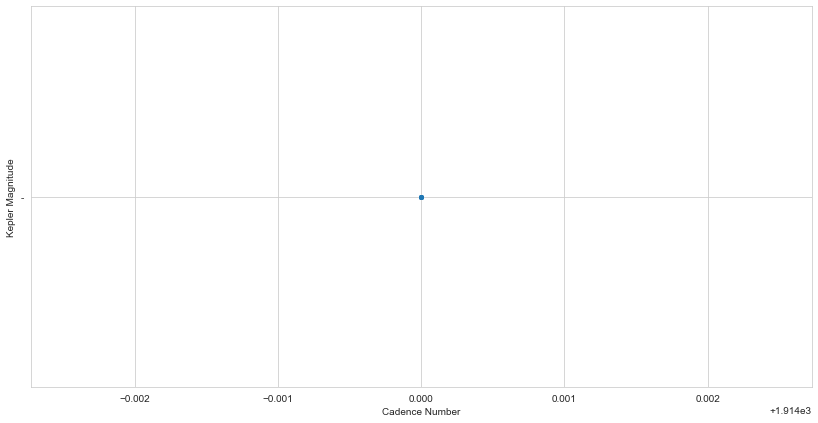

In [46]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,7))
plt.scatter(df[0],df[10],s=15)
plt.xlabel('Cadence Number')
plt.ylabel('Kepler Magnitude')